# Singular Value Decomposition

Recognizing trends and making proper detrending procedures are
an important step toward robust analysis. There is no unique 
definition of the trend. Subsequently, any proper algorithm for
extracting trends from underlying data sets should remove embedded
trends without destroying intrinsic fluctuations as much as
possible. For real-world data sets the mentioned situation
needs more precise considerations. It was demonstrated that
Multifractal detrended fluctuation analysis (MF-DFA) is not able
to eliminate the effect of intrinsic periodic trends in data series.
As a result, when MF-DFA applied to data with sinusoidal trends,
spurious crossover occurs in the plot of fluctuation function. 
It can be shown that a periodic trend induces an artificial crossover
at the scale of the sinusoidal periodicity. This crossover leads
to difficulties in analyzing data in a sense that it makes the
estimation of scaling exponent unreliable. Therefore, to
measure the scaling exponent correctly, we have to minimize
the effect of such trends in the data before applying the MF-DFA.
Along this line, various methods have been suggested including
the Fourier filtering method, the empirical mode decomposition (EMD)
method, and the singular value decomposition (SVD) technique. 
Here we use SVD because, comparing with the other two techniques,
it reduces both periodic and quasiperiodic trends in series with
more than one peak in their power spectrums.

Every matrix $M$ can be seen as a linear transformation. It is shown that this transformation can be decomposed in three sub-transformations (using three another matrices $U$, $\Sigma$, and $V^*$): 1. rotation, 2. re-scaling, 3. rotation (See https://en.wikipedia.org/wiki/Singular_value_decomposition for more details. The follwoing figure is from this page).





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd  # singular value decomposition

%matplotlib inline

In [2]:
np.random.seed(0)

## Sapmle time series (noise + trend)

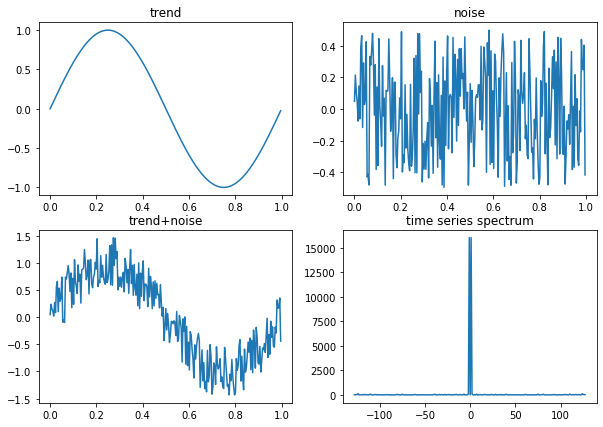

In [3]:
N = 256  # length of the time series
t = np.arange(N)/N

trend = np.sin(2*np.pi*t)
noise = np.random.rand(N) - 0.5

sp = np.abs(np.fft.fft(trend+noise))**2

time_step = t[1]-t[0]
freqs = np.fft.fftfreq(N, time_step)
idx = np.argsort(freqs)


plt.rcParams["figure.figsize"]=[10,7]

fig,a =  plt.subplots(2,2)
a[0][0].plot(t,trend)
a[0][0].set_title('trend')

a[0][1].plot(t,noise)
a[0][1].set_title('noise')

a[1][0].plot(t,trend+noise)
a[1][0].set_title('trend+noise')

a[1][1].plot(freqs[idx], sp[idx])
#a[1][1].plot(freq, sp)
a[1][1].set_title('time series spectrum')
plt.show()

# SVD Algorithm

## Step 1
For a series $\{x_i|i=1,...,N\}$ with periodic or quasiperiodic
trends, the first step is to find the number of periodic or quasiperiodic
components of the data series using its power spectrum. This number
is denoted by $p$.

In [4]:
np.where(sp == max(sp))

(array([  1, 255]),)

In [5]:
freqs[1]

1.0

In [6]:
# find the first three largest values in power spectrum
A = [i for i in sorted(sp,reverse=True)][0:6]
A = A[0],A[2],A[4]
A

(16006.51038232545, 129.74228988651058, 97.24276653452048)

In [7]:
# find the corresponding index
index = [np.where(sp == i) for i in A]
index
largest_index = index[0][0][0],index[1][0][0],index[2][0][0]
largest_index

(1, 124, 2)

In [8]:
# find the corresponding frequencies
[freqs[i] for i in largest_index]

[1.0, 124.0, 2.0]

In [9]:
# the number of periodic or quasiperiodic components of the data series
# using its power spectrum that need to be removed in deterending 

p = 3

## Step 2

Construct the matrix $\Gamma = (\gamma_1 ,\gamma_2 , \cdots ,\gamma_d )^T$  , where $\gamma_k =
(x_k ,x_{k+1} , . . . ,x_{k+N−d})$ and the superscript "$T$" represents
the transpose operator. The dimension $d$ of the matrix $\Gamma$ is
called the embedding dimension. Note that, for a power-law
series, the embedding dimension should be chosen much larger
than the number of frequency components $p$.

In [10]:
d = 128 

In [11]:
T = np.zeros( (N-d+1,d) )

for k in range(d): 
    gamma = trend[k:k+N-d+1] + noise[k:k+N-d+1]
    T[:,k] = gamma

In [12]:
T.shape

(129, 128)

## Step 3
Determine singular values in descending order by applying
the SVD on the matrix $\Gamma$. Singular value decomposition
of the matrix $\Gamma_{(N-d+1) \times d}$ is given by $\Gamma = U \Sigma V^T$ ,
where $U_{(N-d+1) \times (N-d+1)}$ and $V_{d \times d}$ are two orthogonal matrices
and $\Sigma_{(N-d+1) \times d}$ is the diagonal matrix whose eigenvalues are the desired singular values.

In [13]:
# SVD
U, s, VT = svd(T)
#print('U=',U)
#print('s=',s)
#print('VT=', VT)

In [14]:
# create m x n Sigma matrix
Sigma = np.zeros((T.shape[0], T.shape[1]))
# populate Sigma with n x n diagonal matrix
Sigma[:T.shape[1], :T.shape[1]] = np.diag(s)

#U.dot(Sigma.dot(VT))-T

## Step 4

Construct the filtered matrix $\Gamma^{new} = U \Sigma^{new} V^T$ with the
new matrix $\Sigma^{new}$ , which is obtained by setting the first $2p + 1$
eigenvalues of to zero.

In [15]:
s_new = s
s_new[:2*p+1] = 0

Sigma_new = np.zeros((T.shape[0], T.shape[1]))
Sigma_new[:T.shape[1], :T.shape[1]] = np.diag(s_new)

In [16]:
T_new = U.dot(Sigma_new.dot(VT))

## Step 5

Compute detrended data $\{x_i^∗\}$, elements of the filtered
matrix $\Gamma^∗$ , by mapping $\Gamma^∗$ back onto a one-dimensional series

In [17]:
x_new = np.zeros( (T.shape[0]+T.shape[1]-1) )
for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        x_new[i+j] = T_new[i][j]

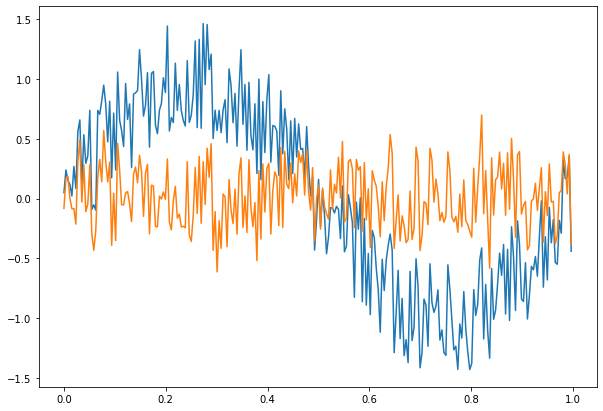

In [18]:
plt.plot(t, trend+noise, t, x_new)
plt.show()

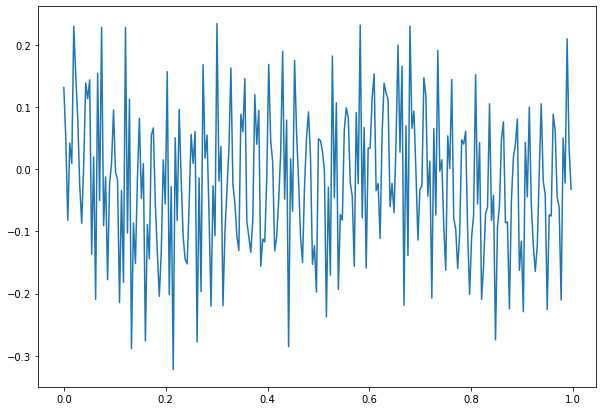

In [19]:
plt.plot(t,noise-x_new)
plt.show()